## I. Data Collection
Oil and gas exploration data is highly expensive and resource-intensive. Drilling operations and seismic surveys can cost millions or even tens of millions of dollars. As a result, the availability of such data is limited compared to conventional datasets. Additionally, training machine learning models requires labeled data, which is not readily available in raw datasets and necessitates expert involvement for annotation.
Therefore, in this project, two main data sources are utilized: publicly accessible reference data and labeled datasets for model training. Specifically:
- USGS Data: Provides free access to well-log data from selected oil fields across the United States.
- ABC Data: A labeled dataset specifically designed for lithology classification tasks.

### 1. USGS API

In [ ]:
import requests
import os

# Define the base URL and item ID
BASE_URL = "https://www.sciencebase.gov/catalog/item/"
item_id = "64d15b1dd34ef477cf3c0228"
item_url = f"{BASE_URL}{item_id}?format=json"
save_dir = f"data/{item_id}"
os.makedirs(save_dir, exist_ok=True)

# Fetch metadata
response = requests.get(item_url)
response.raise_for_status()  # Raise an error for failed requests
data = response.json()

# Extract the file download URL
desired_file_path = "/catalog/file/get/64d15b1dd34ef477cf3c0228?f=__disk__7f%2F82%2Fa2%2F7f82a2ebace8c7dad328776faea0720d94f80968"
download_url = f"https://www.sciencebase.gov{desired_file_path}"

# Download the file
file_response = requests.get(download_url, stream=True)
file_response.raise_for_status()

# Save to local file
file_name = "LAS_Files.zip"
file_path = os.path.join(save_dir, file_name)
with open(file_path, "wb") as file:
    for chunk in file_response.iter_content(chunk_size=8192):
        file.write(chunk)

print(f"File downloaded successfully: {file_name} from {download_url}")

File downloaded successfully: LAS_Files.zip from https://www.sciencebase.gov/catalog/file/get/64d15b1dd34ef477cf3c0228?f=__disk__7f%2F82%2Fa2%2F7f82a2ebace8c7dad328776faea0720d94f80968


### 2. Data Loading

2.1 USGS Data

In [80]:
# Import the necessary libraries
import lasio, zipfile, os
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the downloaded LAS files
las_path = "data/64d15b1dd34ef477cf3c0228/LAS_Files"
zip_file = "data/64d15b1dd34ef477cf3c0228/LAS_Files.zip"

# Unzip the downloaded files
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall("/".join(zip_file.split("/")[:-1]))

# Scan for LAS files
las_files = []
for root, dirs, files in os.walk(las_path):
    for file_name in files:
        if file_name.endswith(".LAS"):
            las_files.append(os.path.join(root, file_name))

# Print the number of LAS files found
print(f"Found {len(las_files)} LAS files")

# Merge all las files into one dataframe
las_df = lasio.read(las_files[0]).df().reset_index()
for path in las_files[1:]:
    _df = lasio.read(path).df().reset_index()
    _df.drop(columns=set(_df.columns) & set(las_df.columns) - {'DEPT'}, inplace=True)
    
    las_df = las_df.merge(_df, on='DEPT', how='outer')

chosen_curves = ['DEPT', 'DEN(SS)', 'DEN(LS)', 'SANG', 'PAD1-AZ', 
                 'AMP 1', 'TEMP', 'MAG-VECT', 'GAMMA', 
                 'TENSION','TOOLFACE', 'GYRO', 'CAGE', 'NEUTRON', 'POR(NEU)']
las_df = las_df.loc[:, las_df.columns.intersection(chosen_curves)]

print(f"Merged {len(las_files)} LAS files to final dataframe")

las_df.head()

Found 7 LAS files
Merged 7 LAS files to final dataframe


,DEPT,DEN(SS),DEN(LS),SANG,PAD1-AZ,AMP 1,TEMP,MAG-VECT,GAMMA,TENSION,TOOLFACE,GYRO,CAGE,NEUTRON,POR(NEU)
0,-4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195.7,31.8,-999.0,NaN,NaN


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

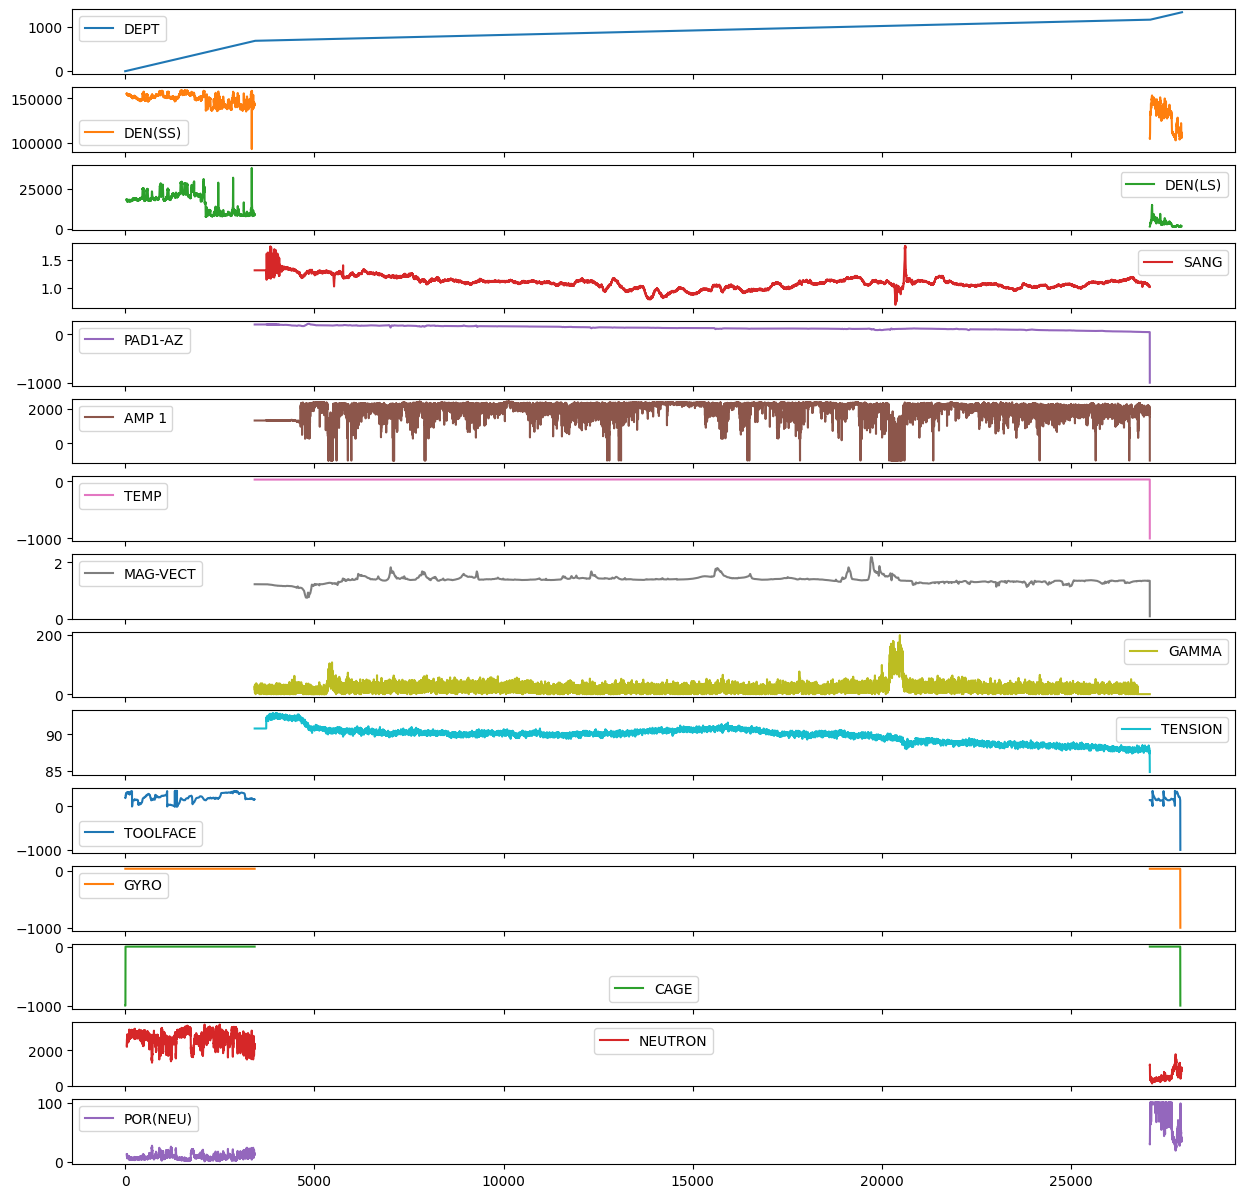

In [81]:
las_df.plot(subplots=True, figsize=(15, 15))

2.2 FORCE Data

In [91]:
# Scan all 2020 FORCE .las files
force_files = []
for root, dirs, files in os.walk("data/2020_force"):
    for file_name in files:
        if file_name.endswith(".las"):
            force_files.append(os.path.join(root, file_name))
print(f"Found {len(force_files)} LAS files, including:{[os.path.basename(f) for f in force_files]}")

Found 118 LAS files, including:['34_3-1 A.las', '31_2-8.las', '31_2-9.las', '34_12-1.las', '35_12-1.las', '7_1-2 S.las', '34_4-10 R.las', '34_2-4.las', '31_5-4 S.las', '16_10-5.las', '25_4-5.las', '34_3-3 A.las', '25_11-15.las', '25_6-2.las', '34_7-21.las', '34_7-20.las', '25_6-3.las', '36_7-3.las', '35_4-1.las', '25_2-7.las', '16_10-1.las', '33_9-1.las', '16_8-1.las', '16_10-3.las', '16_2-16.las', '25_6-1.las', '25_11-5.las', '16_10-2.las', '31_6-8.las', '35_9-8.las', '34_10-16 R.las', '34_11-1.las', '35_11-1.las', '35_9-6 S.las', '25_5-4.las', '15_9-17.las', '15_9-15.las', '25_2-14.las', '35_3-7 S.las', '25_3-1.las', '15_9-14.las', '35_11-7.las', '25_5-3.las', '25_11-19 S.las', '34_8-7 R.las', '35_11-6.las', '35_8-6 S.las', '25_7-2.las', '15_9-13.las', '17_11-1.las', '25_5-1.las', '26_4-1.las', '35_11-5.las', '34_3-2 S.las', '25_9-1.las', '31_3-2.las', '16_11-1 ST3.las', '15_9-23.las', '35_11-11.las', '16_5-3.las', '34_10-33.las', '35_11-10.las', '16_2-11 A.las', '31_3-3.las', '32_2-

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

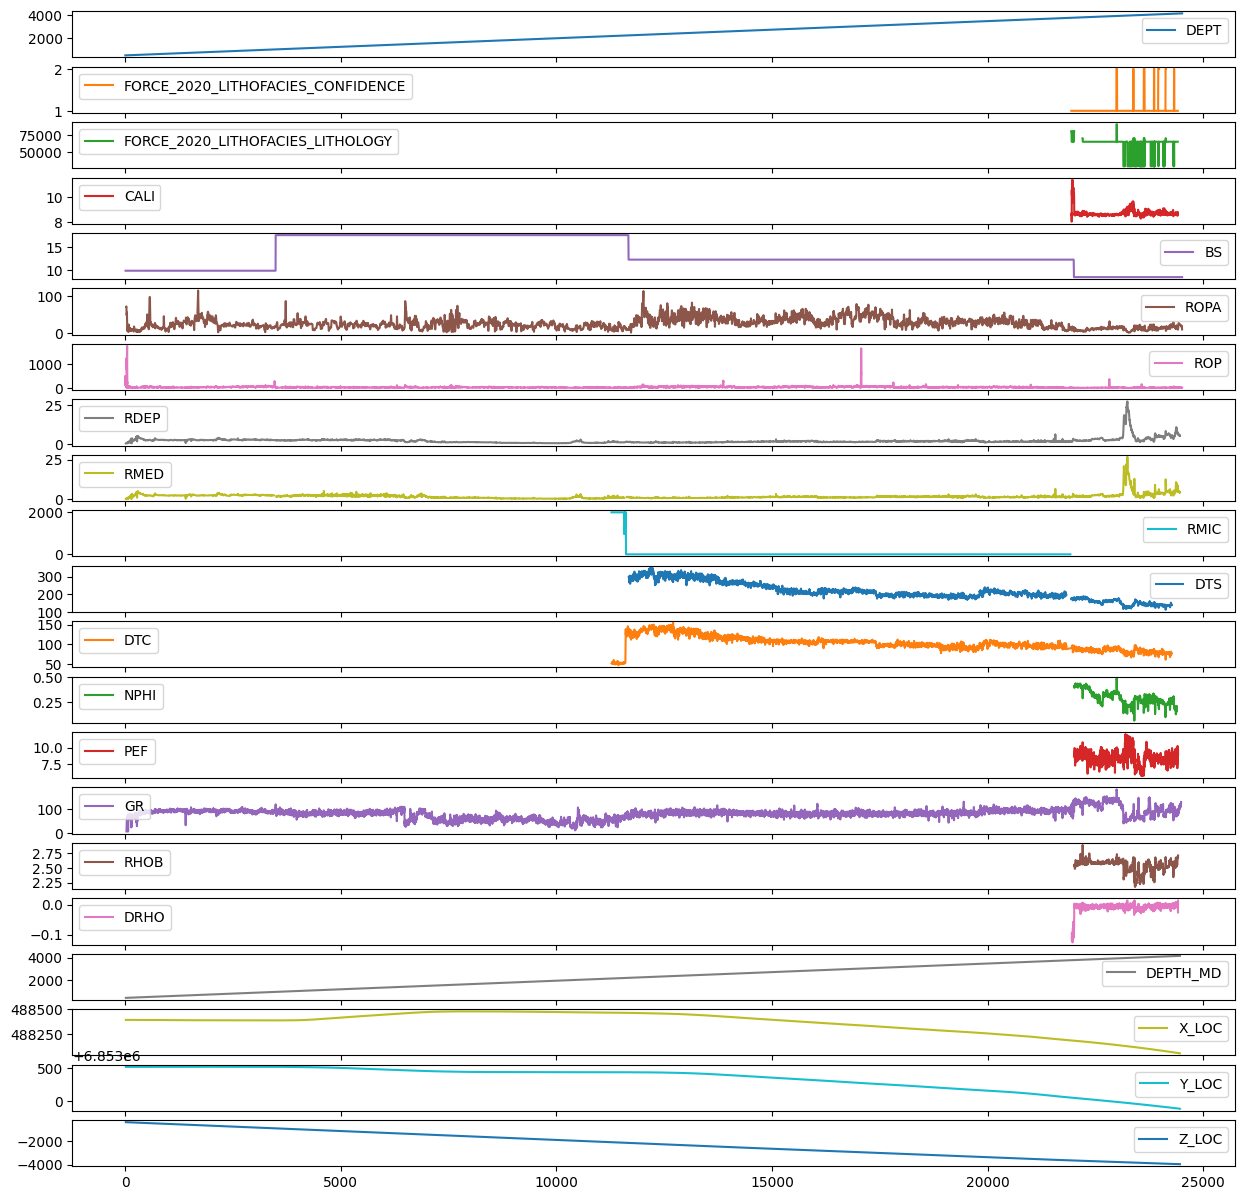

In [92]:
# Load the first file
force_df = lasio.read(force_files[0]).df().reset_index()
force_df.plot(subplots=True, figsize=(15, 15))

### Data Preprocessing and Visualization

In [94]:
las = lasio.read(force_files[0])
for count, curve in enumerate(las.curves):
    print(f"Curve: {curve.mnemonic}, \t Units: {curve.unit}, \t Description: {curve.descr}")
print(f"There are a total of: {count+1} curves present within this file")

Curve: DEPT, 	 Units: m, 	 Description: DEPTH
Curve: FORCE_2020_LITHOFACIES_CONFIDENCE, 	 Units: _, 	 Description: FORCE_2020_LITHOFACIES_CONFIDENCE
Curve: FORCE_2020_LITHOFACIES_LITHOLOGY, 	 Units: _, 	 Description: FORCE_2020_LITHOFACIES_LITHOLOGY
Curve: CALI, 	 Units: in, 	 Description: CALI
Curve: BS, 	 Units: in, 	 Description: BS
Curve: ROPA, 	 Units: _, 	 Description: ROPA
Curve: ROP, 	 Units: m/h, 	 Description: ROP
Curve: RDEP, 	 Units: ohm.m, 	 Description: RDEP
Curve: RMED, 	 Units: ohm.m, 	 Description: RMED
Curve: RMIC, 	 Units: ohm.m, 	 Description: RMIC
Curve: DTS, 	 Units: us/ft, 	 Description: DTS
Curve: DTC, 	 Units: us/ft, 	 Description: DTC
Curve: NPHI, 	 Units: m3/m3, 	 Description: NPHI
Curve: PEF, 	 Units: b/e, 	 Description: PEF
Curve: GR, 	 Units: gAPI, 	 Description: GR
Curve: RHOB, 	 Units: g/cm3, 	 Description: RHOB
Curve: DRHO, 	 Units: g/cm3, 	 Description: DRHO
Curve: DEPTH_MD, 	 Units: _, 	 Description: DEPTH_MD
Curve: X_LOC, 	 Units: _, 	 Description: x

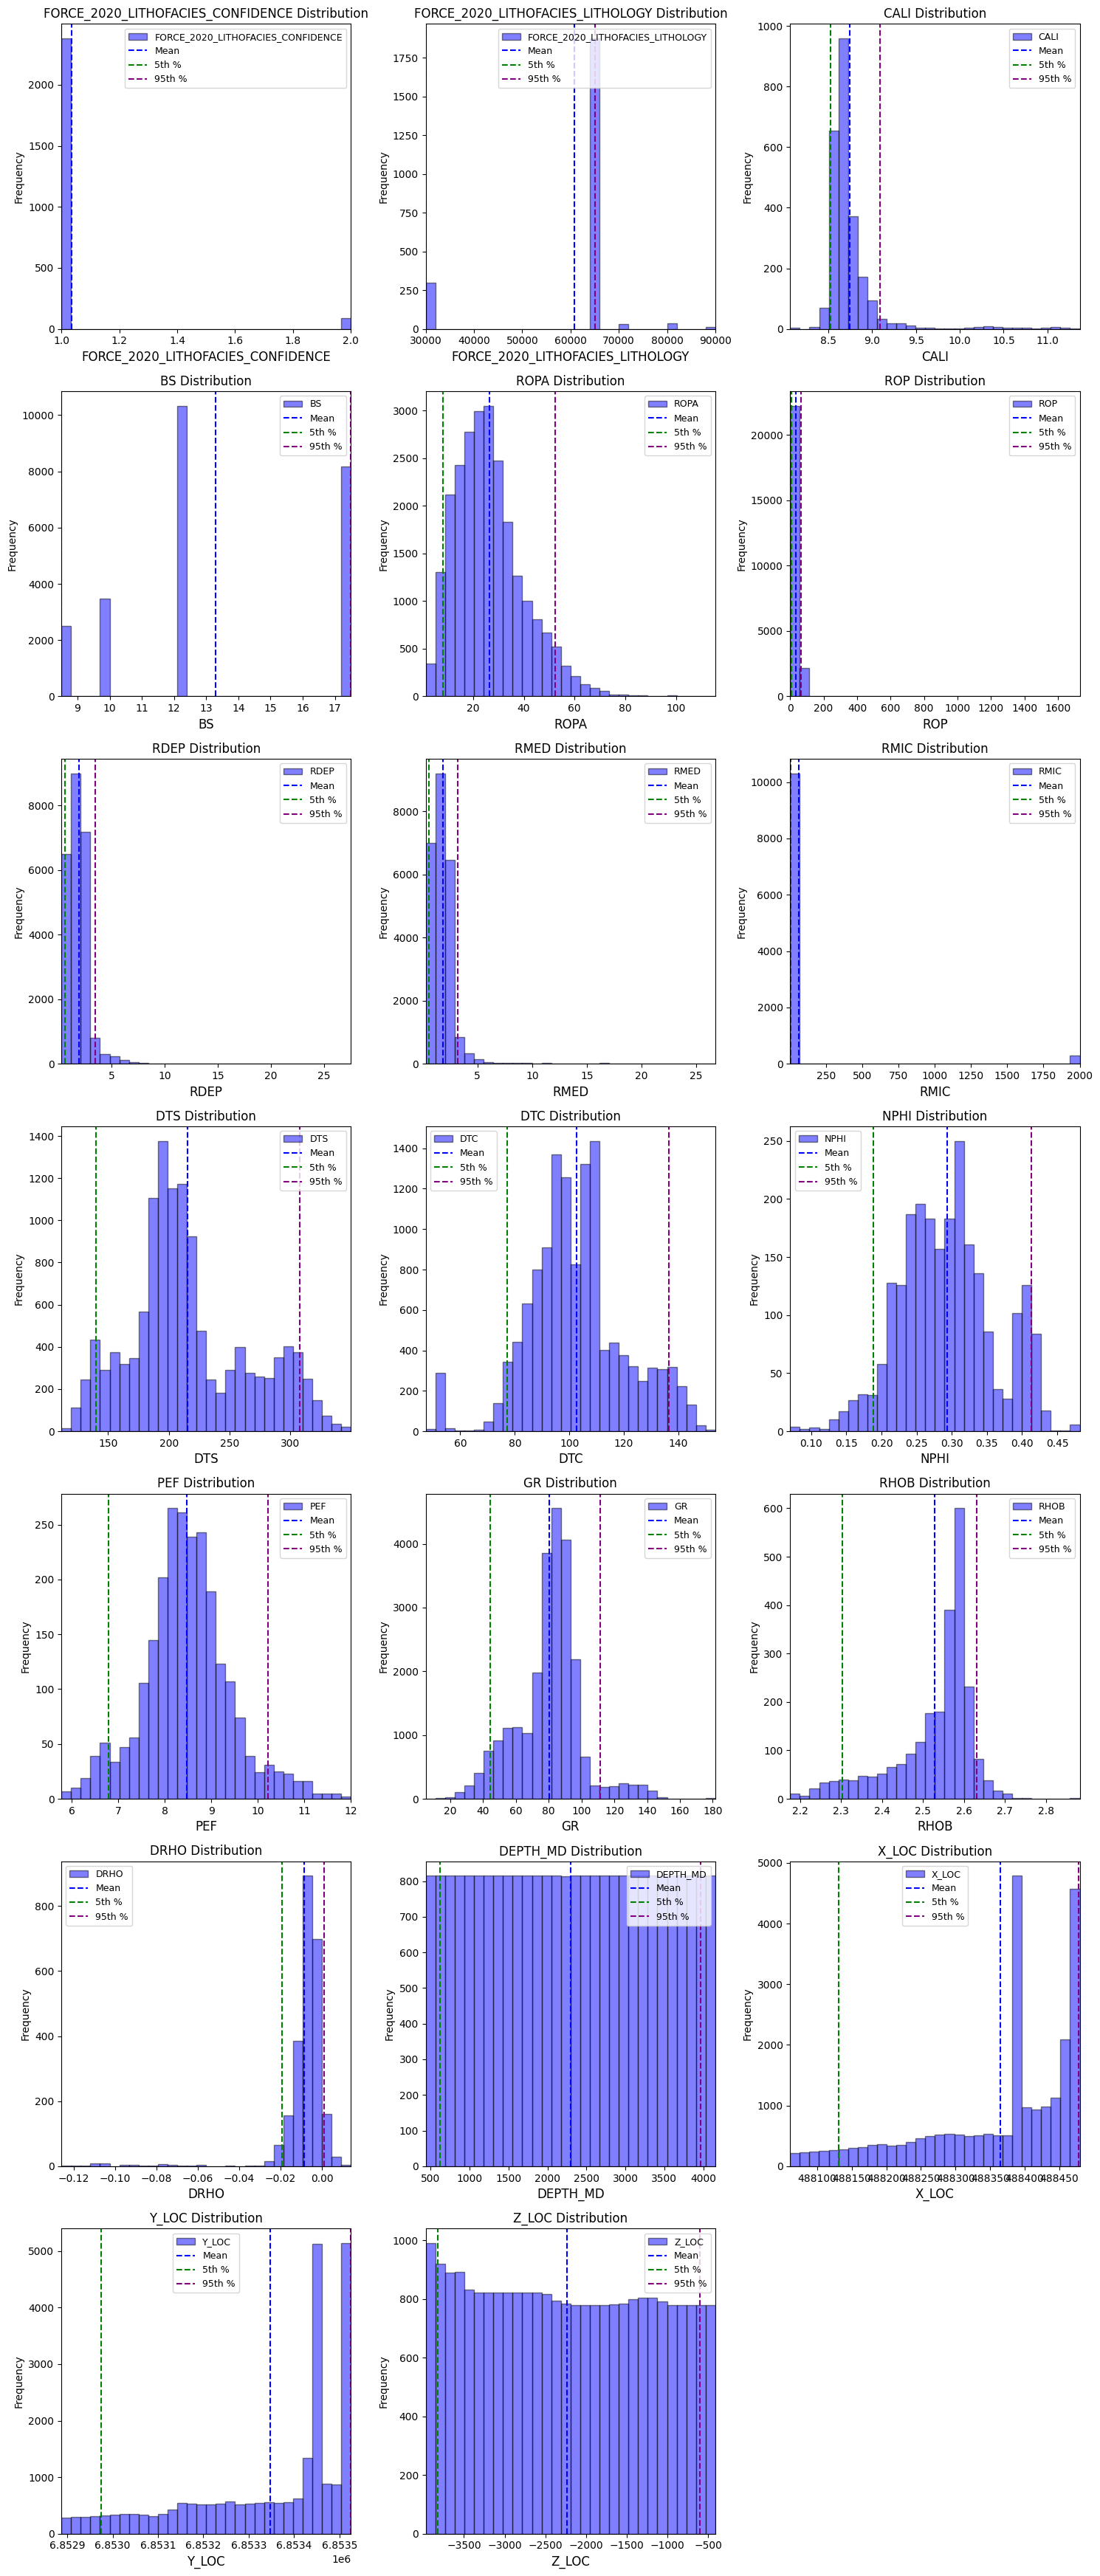

In [100]:
import matplotlib.pyplot as plt
import lasio
import numpy as np

# Load LAS file and extract dataframe
df = las.df()

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Define grid size: 3 columns and dynamically determine rows
num_cols = len(numeric_cols)
num_rows = int(np.ceil(num_cols / 3))  # Ensure enough rows for all columns

# Create subplots with 3 columns
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))  # Adjust figure size dynamically
axes = axes.flatten()  # Flatten grid for easy indexing

# Loop through columns and plot histograms
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    col_mean = df[col].mean()
    col_p5 = df[col].quantile(0.05)
    col_p95 = df[col].quantile(0.95)

    df[col].plot(kind='hist', bins=30, color='blue', alpha=0.5, edgecolor='black', ax=ax)
    ax.axvline(col_mean, color='blue', linestyle='--', label='Mean')
    ax.axvline(col_p5, color='green', linestyle='--', label='5th %')
    ax.axvline(col_p95, color='purple', linestyle='--', label='95th %')

    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_xlim(df[col].min(), df[col].max())
    ax.legend(fontsize=9)
    ax.set_title(f'{col} Distribution', fontsize=12)

# Hide empty subplots if any (in case columns < total subplots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


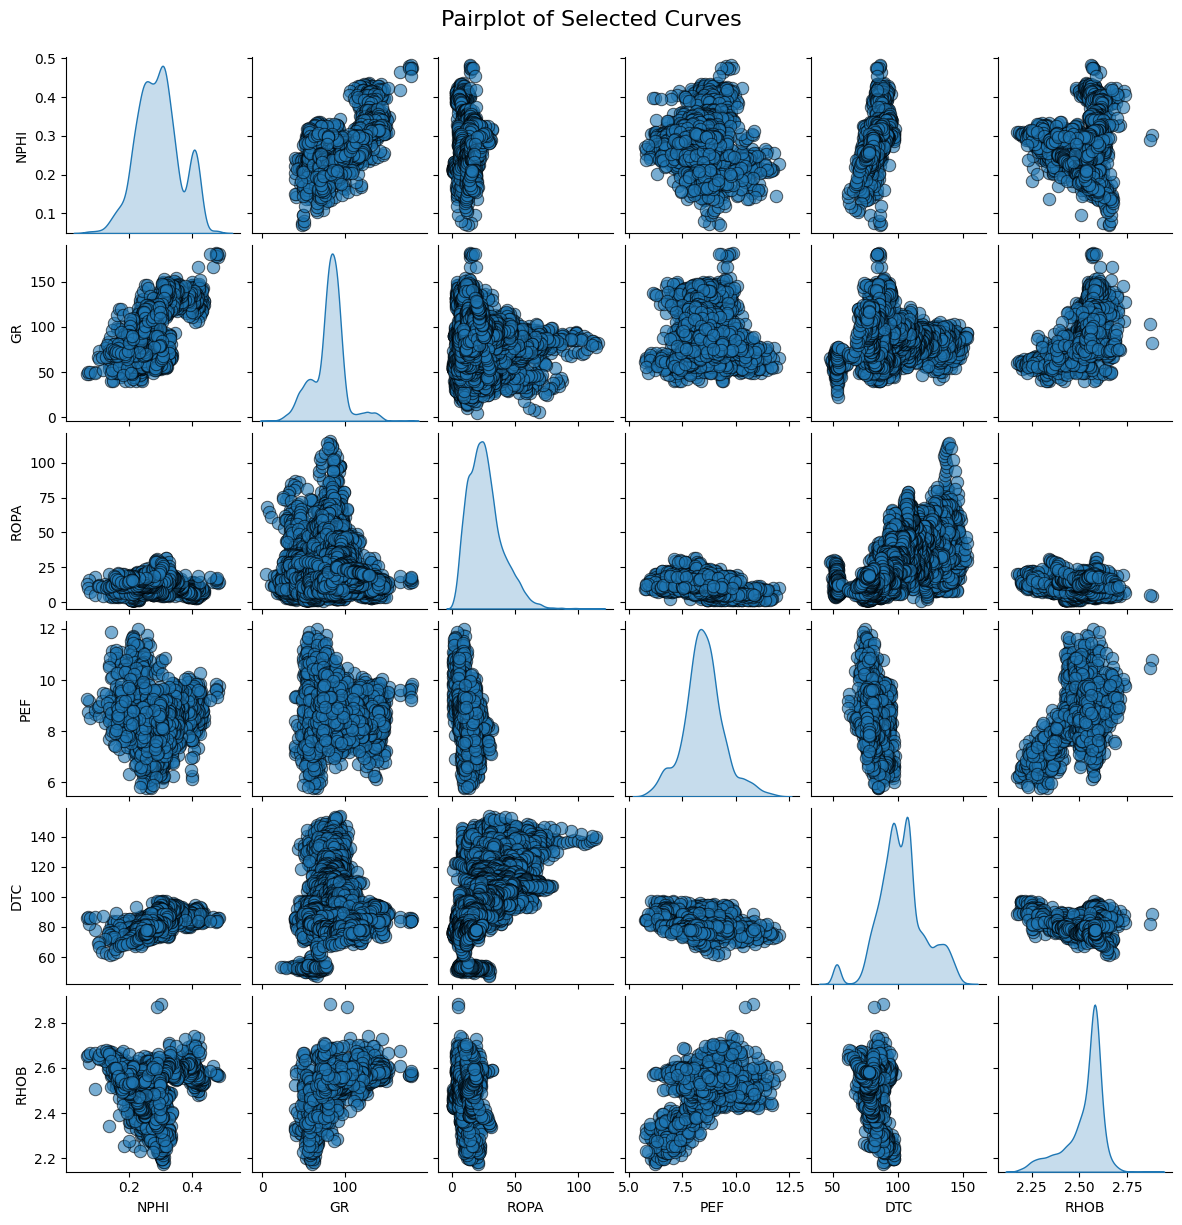

In [108]:
# pairplot
import seaborn as sns

# Select a subset of columns for pairplot
pair_cols = ['NPHI', 'GR', 'ROPA', 'PEF', 'DTC', 'RHOB']

# Create pairplot
sns.pairplot(df[pair_cols], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height=2)
plt.suptitle('Pairplot of Selected Curves', y=1.02, fontsize=16)
plt.show()

In [113]:
df = df.reset_index()
df.head()

,DEPT,FORCE_2020_LITHOFACIES_CONFIDENCE,FORCE_2020_LITHOFACIES_LITHOLOGY,CALI,BS,ROPA,ROP,RDEP,RMED,RMIC,...,DTC,NPHI,PEF,GR,RHOB,DRHO,DEPTH_MD,X_LOC,Y_LOC,Z_LOC
0,436.216715,NaN,NaN,NaN,NaN,NaN,484.595093,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,436.368715,NaN,NaN,NaN,NaN,NaN,248.021545,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,436.520715,NaN,NaN,NaN,NaN,NaN,163.891479,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,436.672715,NaN,NaN,NaN,NaN,NaN,107.911980,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,436.824715,NaN,NaN,NaN,NaN,NaN,96.232262,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


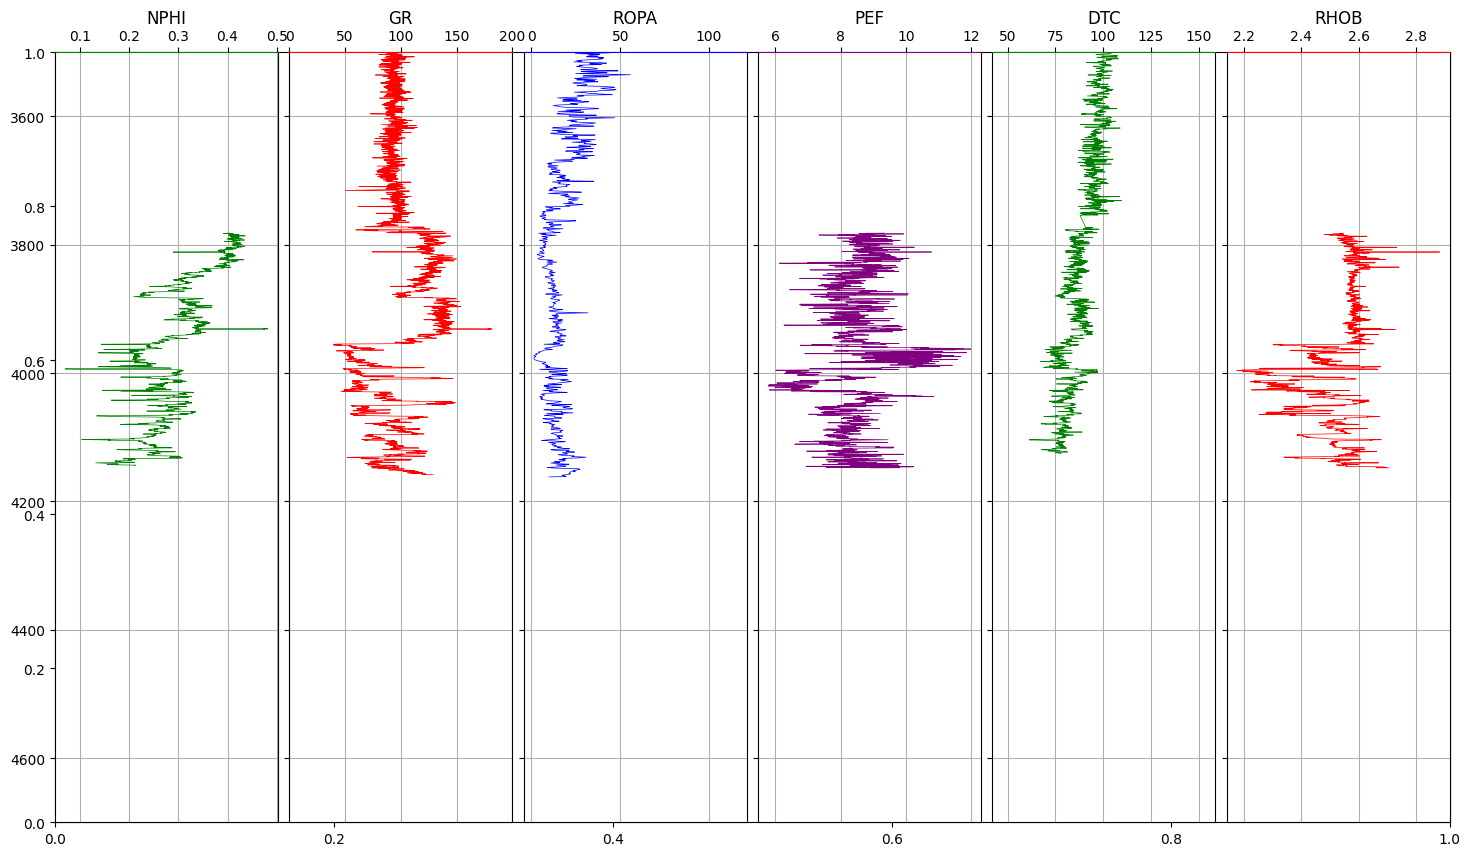

In [114]:
import matplotlib.pyplot as plt

def plot_well_logs(las_df, col_list):
    """
    Plots well-log curves from a LAS DataFrame.
    
    Parameters:
    las_df : pandas DataFrame
        The well-log data extracted from a LAS file.
    col_list : list
        A list of column names to plot.
    """
    num_cols = len(col_list)
    
    # Set up figure and axes dynamically based on number of columns
    fig, axes = plt.subplots(figsize=(num_cols * 3, 10))  # Adjust width based on column count
    
    # Initialize subplots for each column
    ax_list = [plt.subplot2grid((1, num_cols), (0, i), rowspan=1, colspan=1) for i in range(num_cols)]
    
    # Loop through each column and create the respective plot
    for i, col in enumerate(col_list):
        ax = ax_list[i]
        color = ['green', 'red', 'blue', 'purple'][i % 4]  # Cycle colors for better visualization
        
        ax.plot(las_df[col], las_df["DEPT"], color=color, lw=0.5)
        
        # Set axis limits based on column type
        if "GR" in col:
            ax.set_xlim(0, 200)
        elif "RDEP" in col:
            ax.set_xlim(0.2, 2000)
            ax.semilogx()
        elif "DEN" in col:
            ax.set_xlim(1.95, 2.95)
        elif "NEU" in col:
            ax.set_xlim(45, -15)
        
        ax.spines['top'].set_edgecolor(color)
        ax.set_xlabel(col, fontsize=12)
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.set_ylim(4700, 3500)  # Set the depth range
        ax.grid()
        
        # Handle dual-axis for neutron (NEU) log
        if "NEU" in col:
            ax_twiny = ax.twiny()
            ax_twiny.plot(las_df[col], las_df["DEPT"], color="blue", lw=0.5)
            ax_twiny.set_xlim(45, -15)
            ax_twiny.spines['top'].set_edgecolor("blue")
            ax_twiny.spines["top"].set_position(("axes", 1.08))
    
    # Hide y-axis labels for all but the first column
    for ax in ax_list[1:]:
        plt.setp(ax.get_yticklabels(), visible=False)

    # Reduce space between subplots
    fig.subplots_adjust(wspace=0.05)
    
    # Save and display plot
    plt.savefig('logplot.png', dpi=150)
    plt.show()

col_list = ['NPHI', 'GR', 'ROPA', 'PEF', 'DTC', 'RHOB']
plot_well_logs(df, col_list)

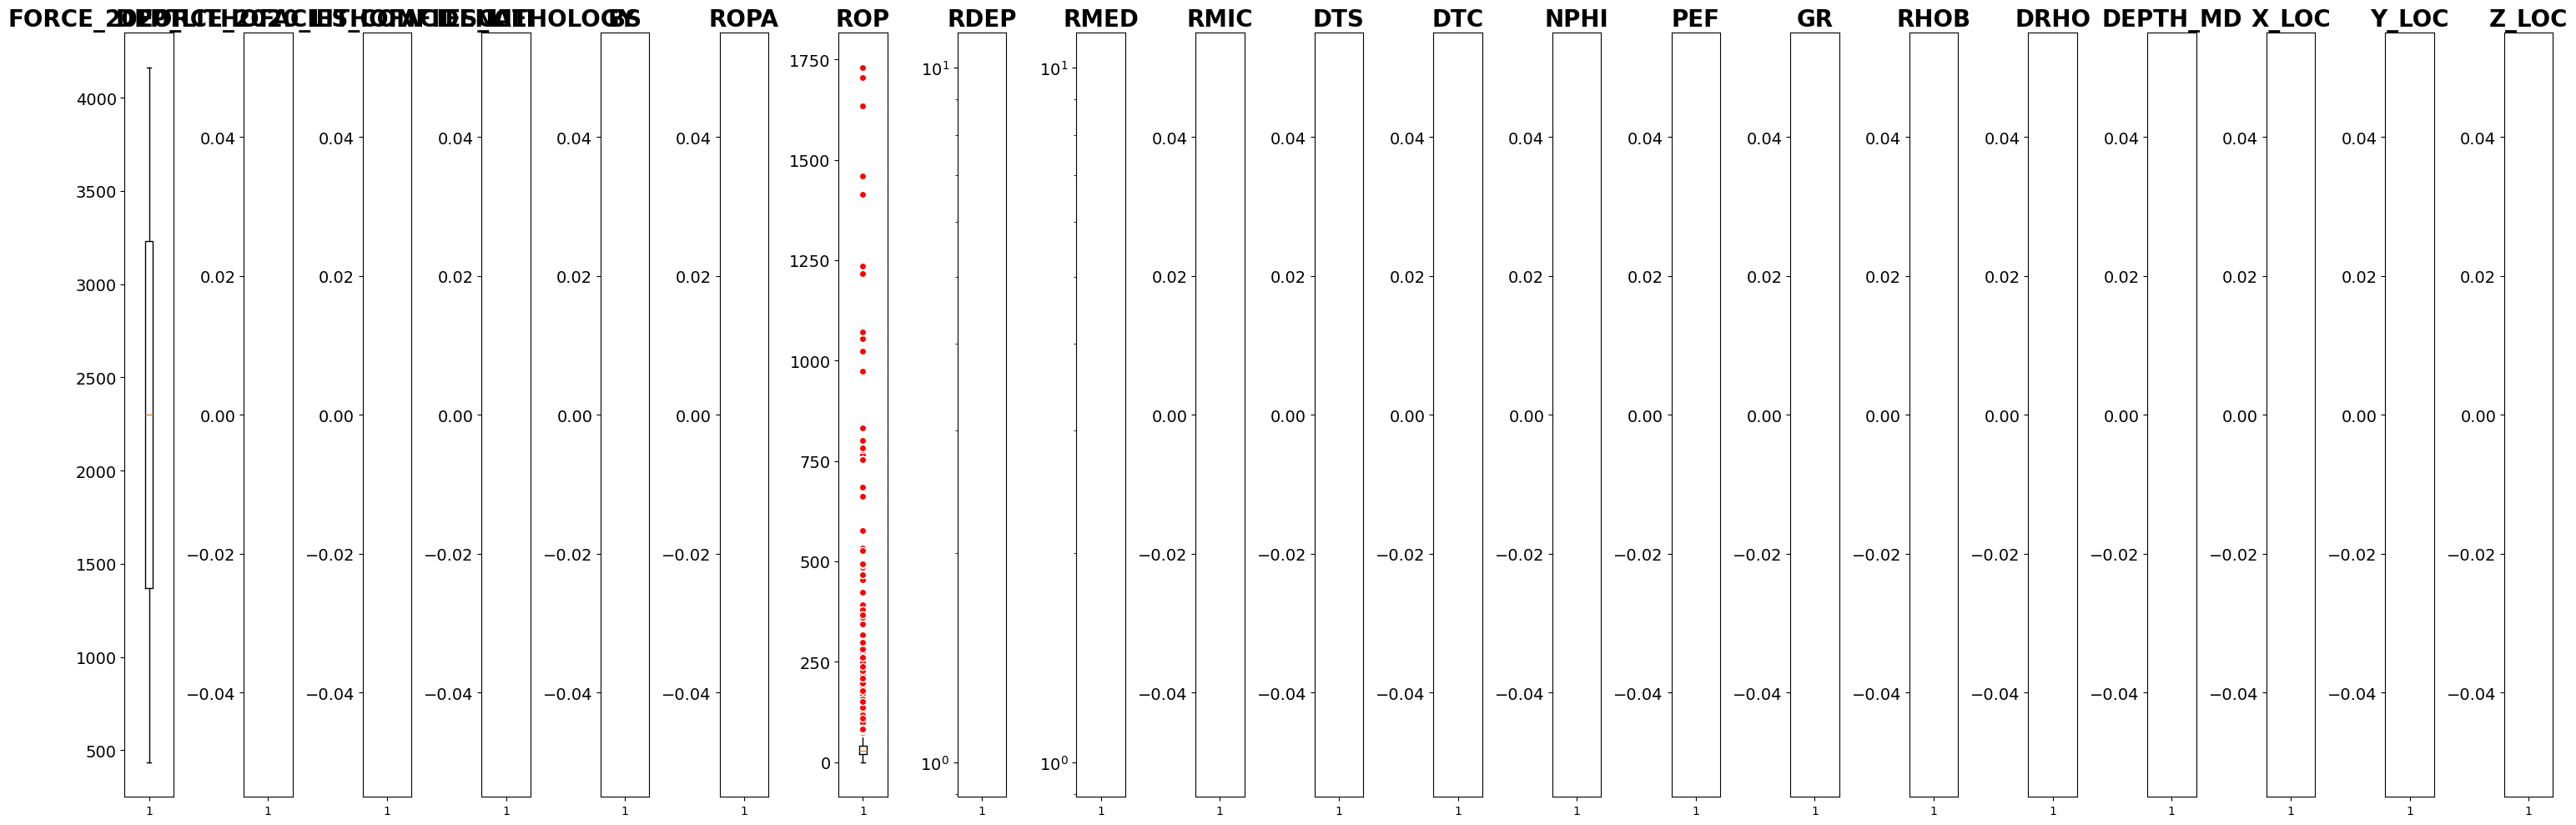

In [116]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(df.columns), figsize=(30,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df.iloc[:,i], flierprops=red_circle)
    df.iloc[:,i]
    ax.set_title(df.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
    #Checking if column names are equal to columns we expect to be logarithmic
    if df.columns[i] == 'RDEP' or df.columns[i] == 'RMED':
        ax.semilogy()
    
plt.tight_layout()

<Axes: >

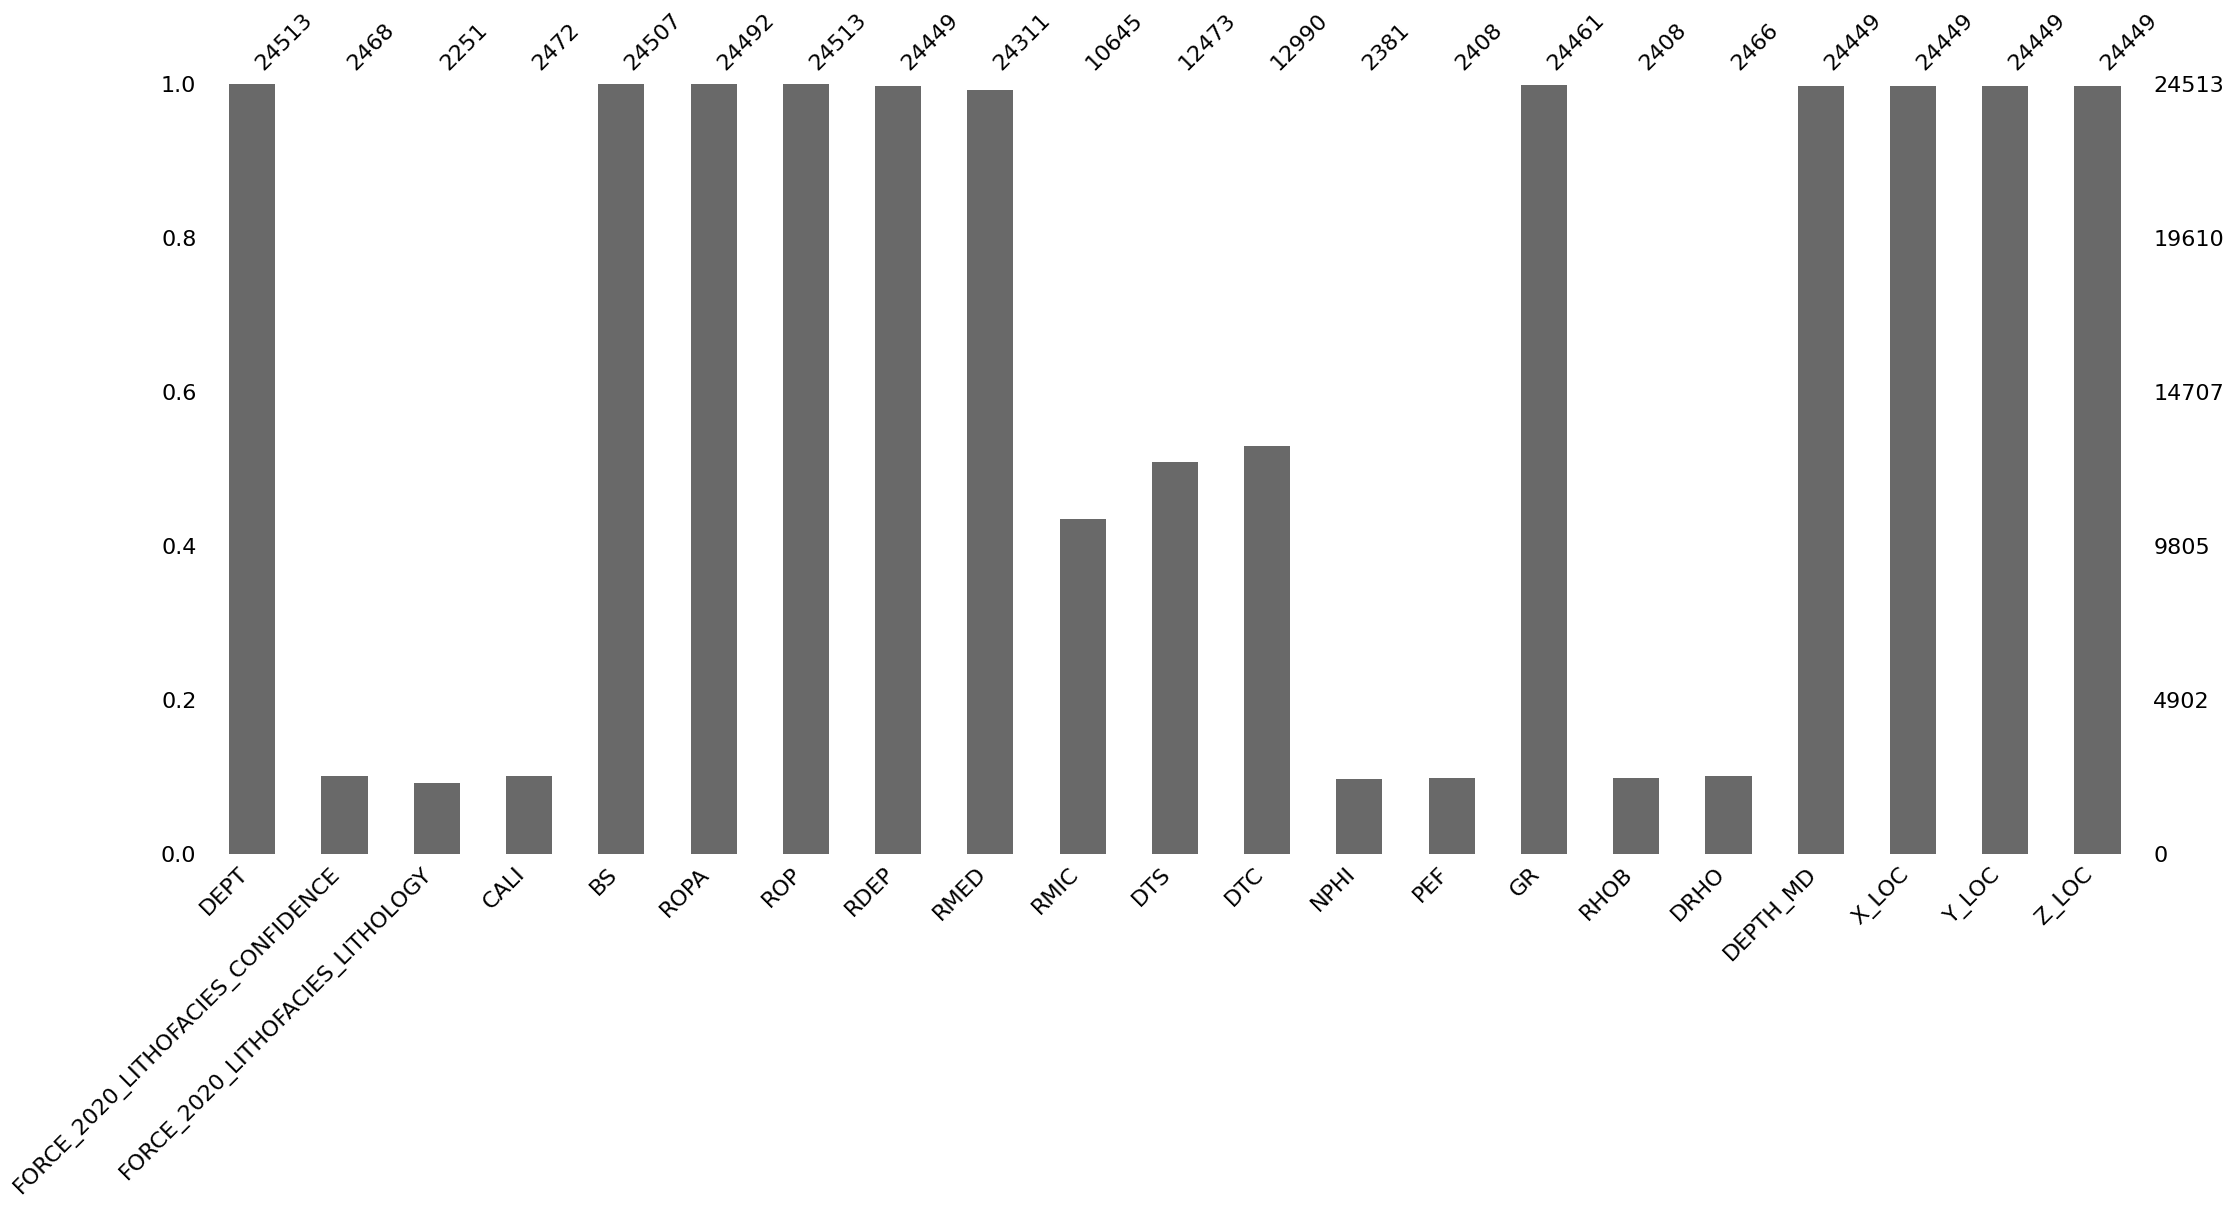

In [119]:
import missingno as msno
#Bar Chart
msno.bar(df)

<Axes: >

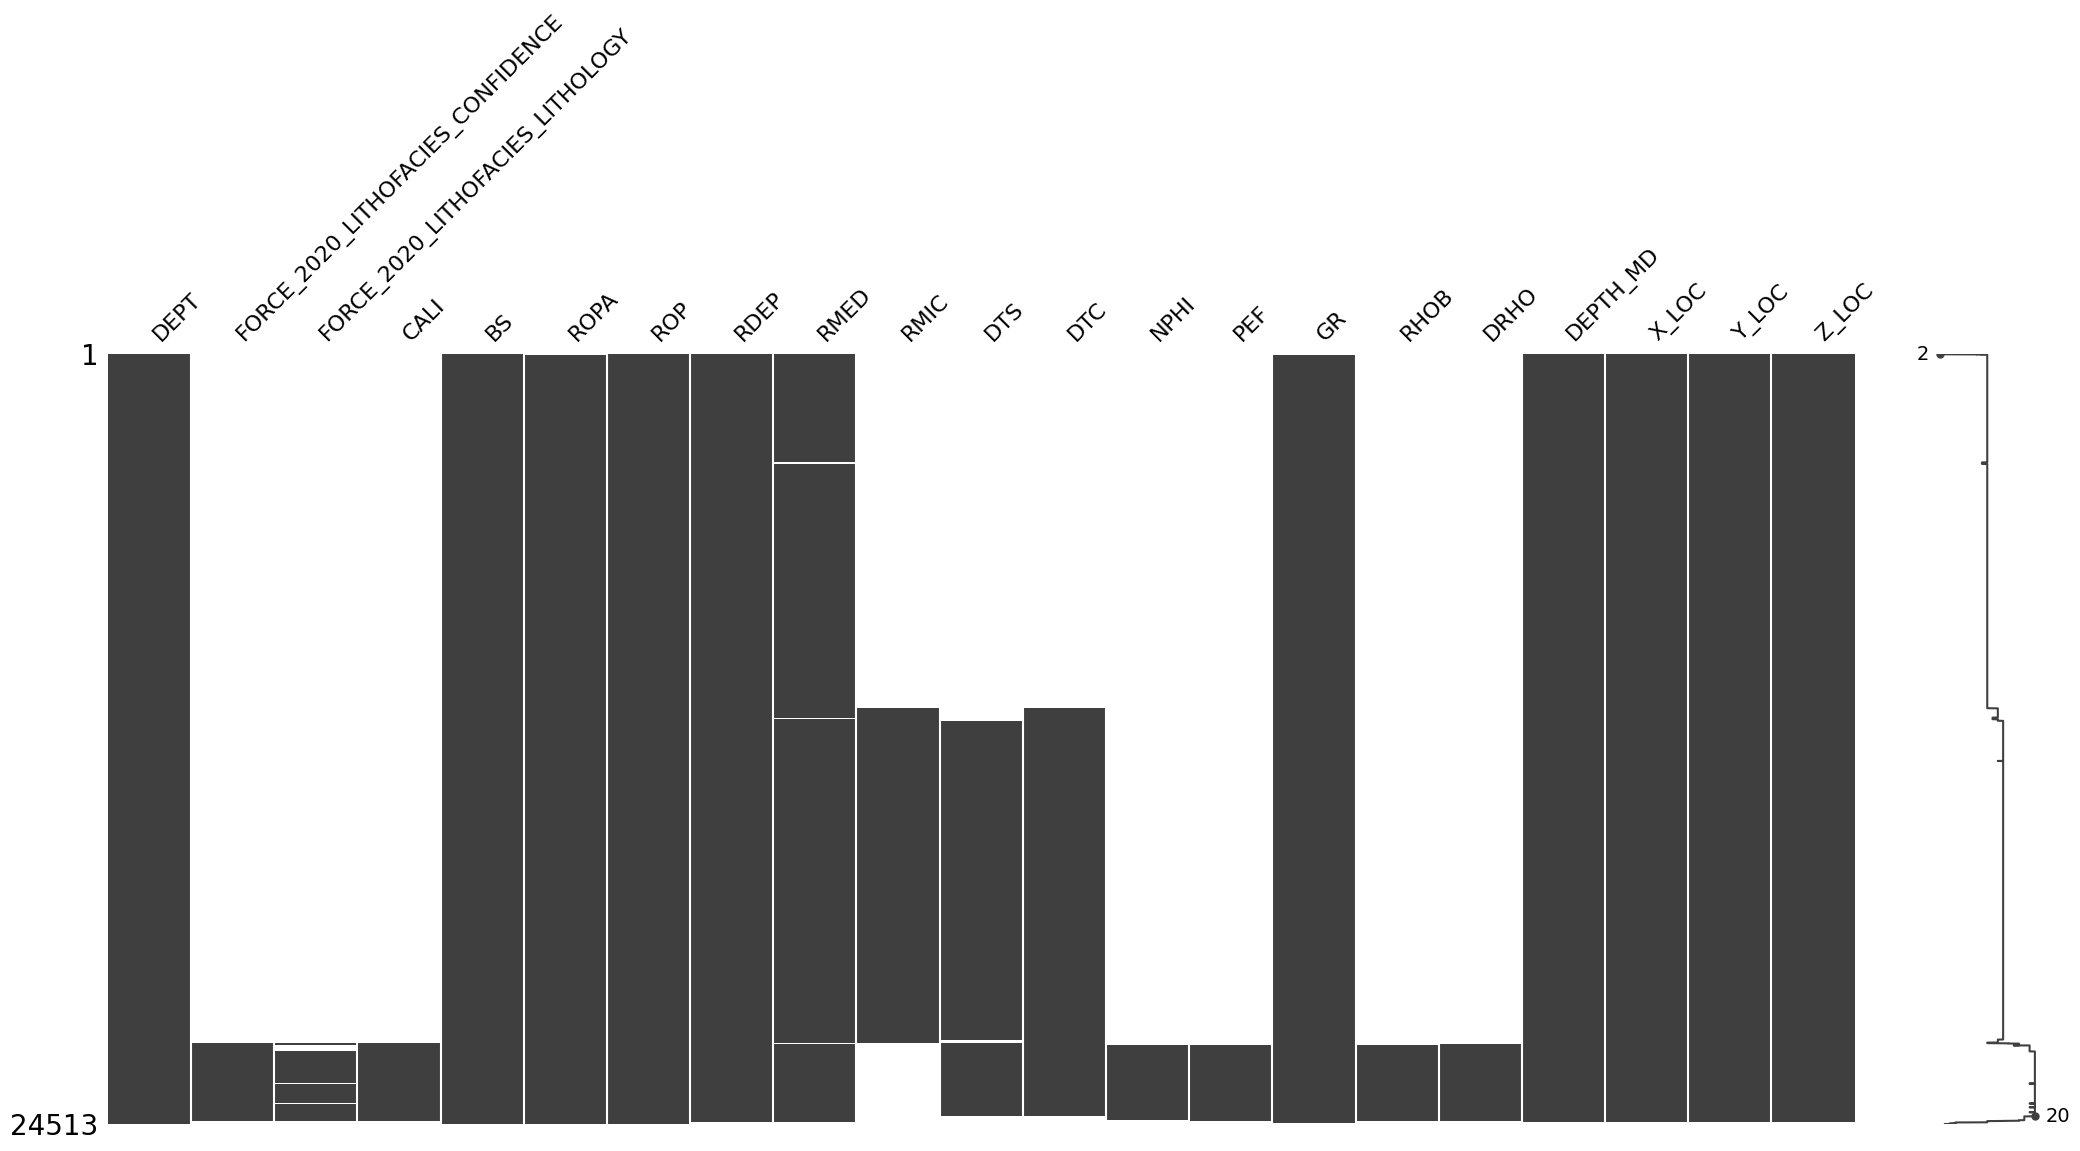

In [120]:
msno.matrix(df)


<Axes: >

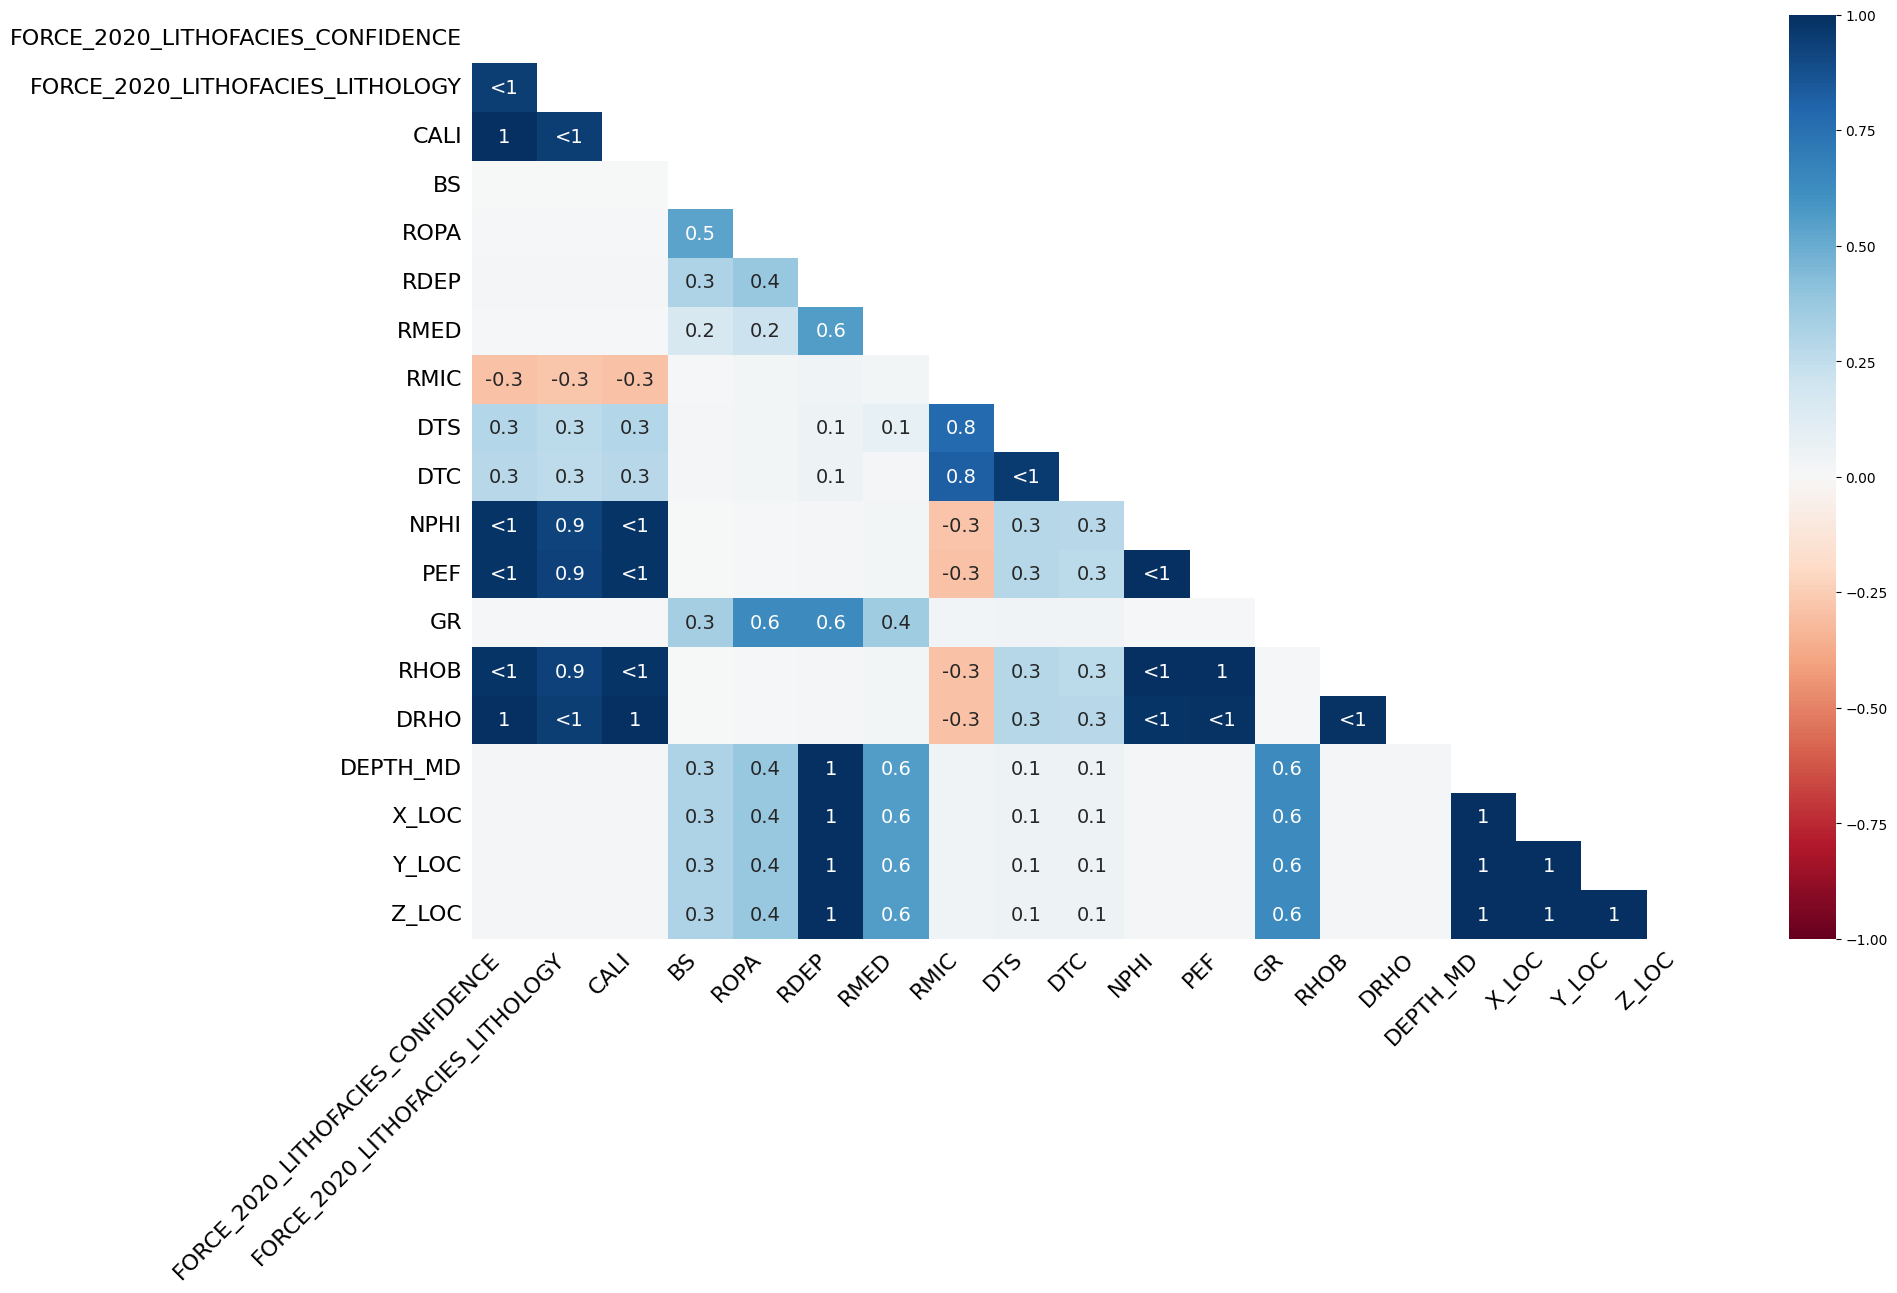

In [122]:
msno.heatmap(df)


<Axes: >

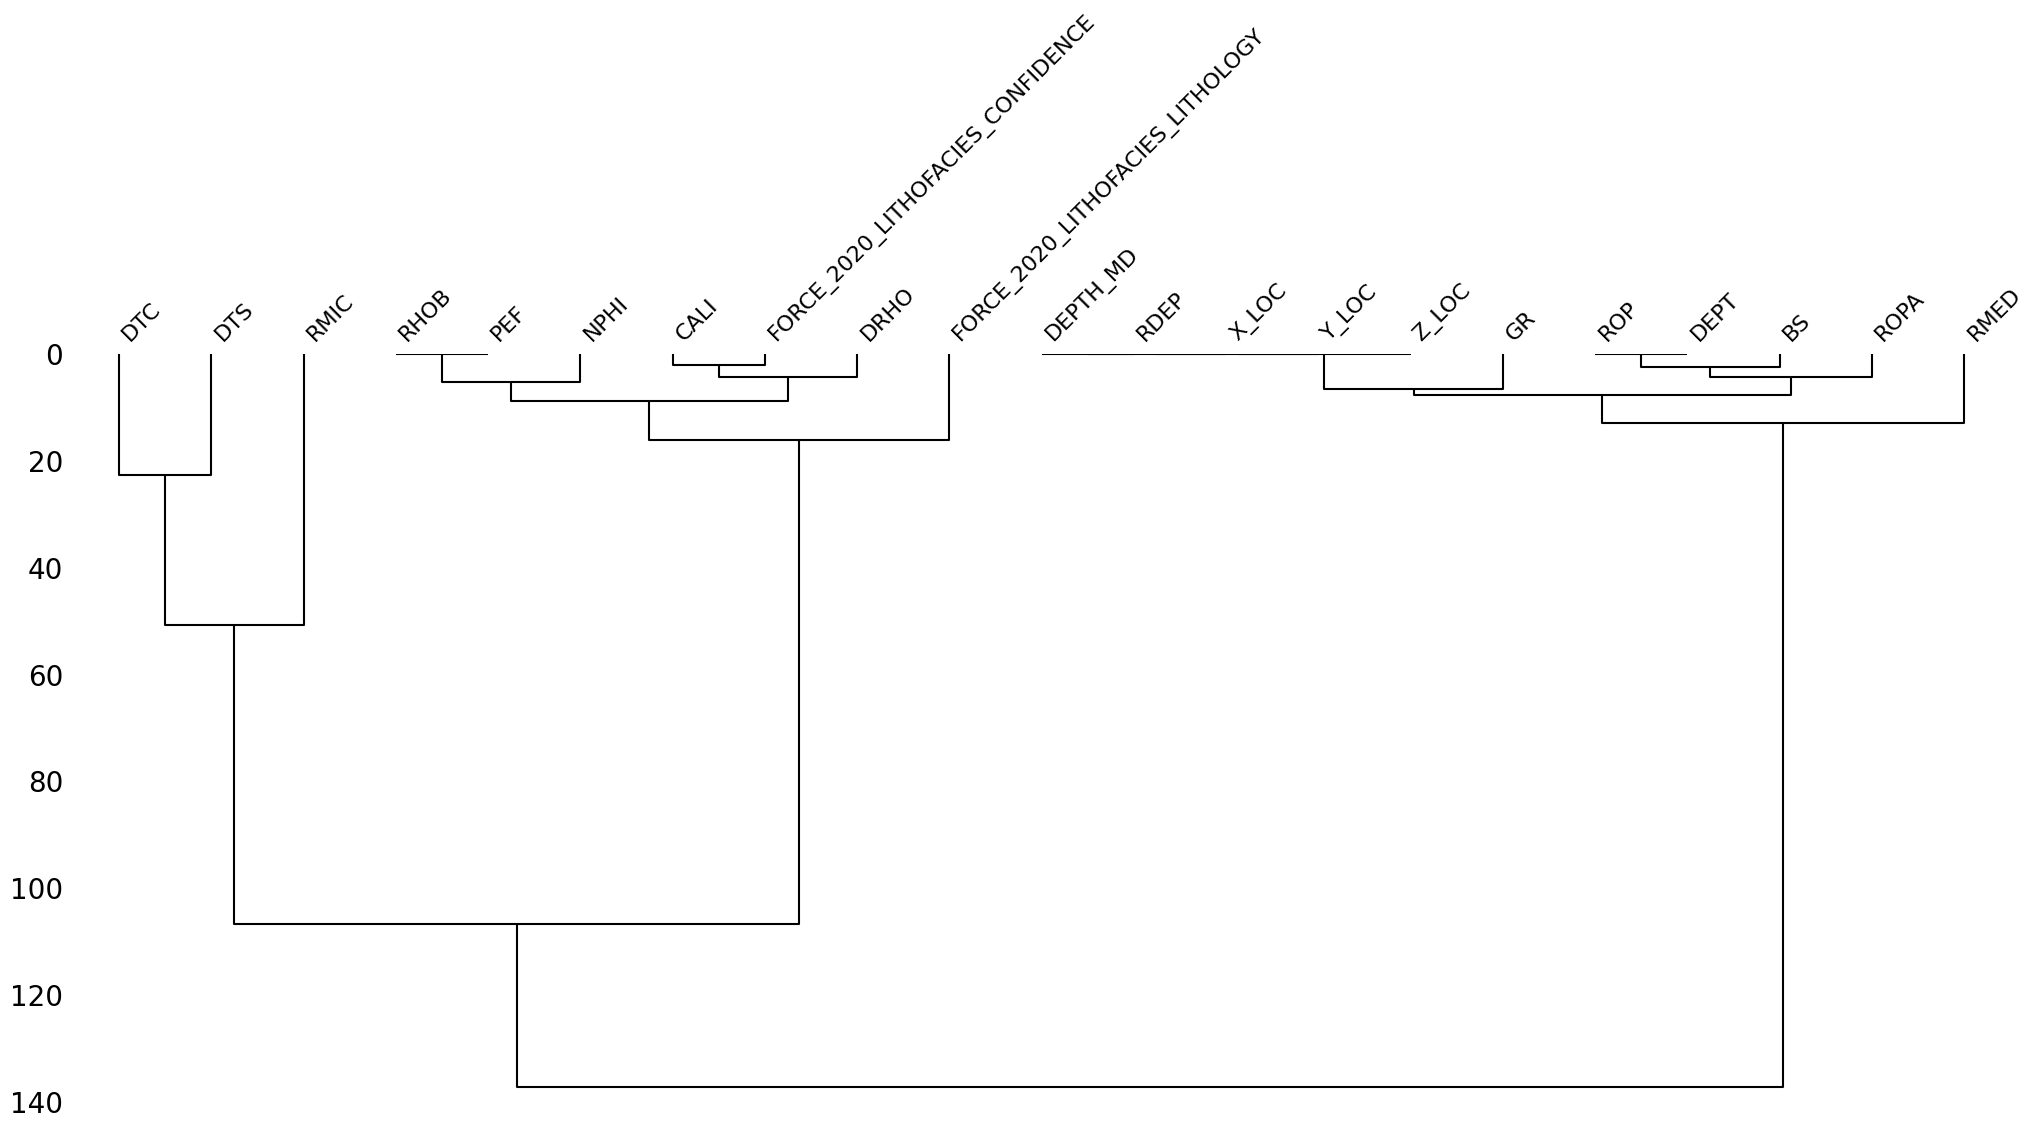

In [123]:
msno.dendrogram(df)
